In [14]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Y, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from matplotlib.pyplot import figure
import time

In [16]:
def findGroundState(pauliSumOp):
    return min(np.linalg.eigh(pauliSumOp.to_matrix())[0])

#Converts SpinOp to PauliSumOp
def convertSpin(ham):
    result = None
    spins = [I, Z, Y, X]
    for c, x, y, z in zip(ham._coeffs, ham.x, ham.y, ham.z):
        spin = x * 3 + y * 2 + z
        pauli = spins[spin[0]]
        for n in range(1, ham.register_length):
            pauli ^= spins[spin[n]]
        pauli *= c
        result = result + pauli if result else pauli
    return result

def makeLatticeIsing(size, cx):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = -1.0  # the interaction parameter corresponds to Z
    v = cx  # the onsite potential corresponds to X

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())

def makeAnsatz(reps = 1, skip = True):
    return TwoLocal(
            rotation_blocks=["rx"],
            entanglement_blocks="rzz",
            entanglement="circular",
            skip_final_rotation_layer = skip,
            reps = reps,
            parameter_prefix="y",)

def findMin(ansatz, reps, cx):
    vqe_solver = VQE(
    ansatz = ansatz,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),)
    
    results = np.full(n, None)
    groundStates = np.full(n, 9999.9)
    times = np.full([n, reps], 0.0)
    for i in range(1, n):
        ising = makeLatticeIsing(i, cx)
        if ising:
            for j in range(reps):
                    result = vqe_solver.compute_minimum_eigenvalue(ising)
                    val = np.real(result.eigenvalue)
                    times[i][j]= result.optimizer_time
                    if val < np.real(groundStates[i]):
                        results[i] = result
                        groundStates[i] = val
                        print(f"Minimum   {i:>2}: {np.round(np.real(result.eigenvalue), 3):<7} " +
                              f"time: {round(result.optimizer_time, 2)}")
                    else:
                        print(f"Processed {i:>2}          time: {round(result.optimizer_time, 2)}")
    return results, groundStates, times

In [74]:
# define maximum size of system
n = 11
#define number of repetitions
r = 5
# Number of x-samples we have
s = 41

samples = [round(-2.0 + (4 * j/(s-1)), 5) for j in range(s)]
print(samples)

[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


In [75]:
# Find True Groundstates of Model
trueGroundStates = np.full([s,n], 0.0)
trueTimes = np.full([s,n], 0.0)
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    for j in range(1, n):
        t1_start = time.time()
        trueGroundStates[i][j] = findGroundState(makeLatticeIsing(j, cx))
        trueTimes[i][j] =  time.time() - t1_start
        print(f"{j:>10}: {round(trueGroundStates[i][j],3):<7} time: {round(trueTimes[i][j],3)}")

X = -2.0:
         1: -2.0    time: 0.002
         2: -4.123  time: 0.005
         3: -6.464  time: 0.009
         4: -8.543  time: 0.012
         5: -10.651 time: 0.017
         6: -12.769 time: 0.023
         7: -14.893 time: 0.03
         8: -17.018 time: 0.044
         9: -19.144 time: 0.089
        10: -21.271 time: 0.477
X = -1.9:
         1: -1.9    time: 0.001
         2: -3.929  time: 0.004
         3: -6.192  time: 0.008
         4: -8.176  time: 0.01
         5: -10.189 time: 0.014
         6: -12.213 time: 0.016
         7: -14.242 time: 0.022
         8: -16.274 time: 0.041
         9: -18.307 time: 0.091
        10: -20.341 time: 0.645
X = -1.8:
         1: -1.8    time: 0.001
         2: -3.736  time: 0.005
         3: -5.924  time: 0.008
         4: -7.813  time: 0.008
         5: -9.731  time: 0.014
         6: -11.662 time: 0.017
         7: -13.598 time: 0.025
         8: -15.537 time: 0.037
         9: -17.478 time: 0.103
        10: -19.419 time: 0.651
X = -1.7:
  

        10: -10.636 time: 0.357
X = 0.6:
         1: -0.6    time: 0.001
         2: -1.562  time: 0.006
         3: -3.344  time: 0.008
         4: -4.403  time: 0.009
         5: -5.479  time: 0.013
         6: -6.563  time: 0.014
         7: -7.651  time: 0.02
         8: -8.741  time: 0.035
         9: -9.832  time: 0.183
        10: -10.923 time: 0.538
X = 0.7:
         1: -0.7    time: 0.001
         2: -1.72   time: 0.004
         3: -3.478  time: 0.01
         4: -4.564  time: 0.011
         5: -5.669  time: 0.013
         6: -6.783  time: 0.016
         7: -7.902  time: 0.022
         8: -9.024  time: 0.058
         9: -10.147 time: 0.077
        10: -11.272 time: 0.371
X = 0.8:
         1: -0.8    time: 0.001
         2: -1.887  time: 0.003
         3: -3.633  time: 0.008
         4: -4.756  time: 0.01
         5: -5.898  time: 0.013
         6: -7.049  time: 0.015
         7: -8.205  time: 0.022
         8: -9.365  time: 0.037
         9: -10.527 time: 0.078
        10: -11.

In [77]:
results = [None] * s
groundStates = [None] * s
times = [None] * s
print(groundStates)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [78]:
ansatz = makeAnsatz()
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    results[i], groundStates[i], times[i] = findMin(ansatz, r, cx)

X = -2.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.01
Minimum    2: -2.562  time: 0.08
Processed  2          time: 0.14
Processed  2          time: 0.07
Processed  2          time: 0.05
Minimum    2: -2.562  time: 0.06
Minimum    3: -4.854  time: 0.18
Processed  3          time: 0.32
Processed  3          time: 0.31
Processed  3          time: 0.23
Minimum    3: -4.854  time: 0.24
Minimum    4: -6.472  time: 0.41
Processed  4          time: 0.34
Processed  4          time: 0.31
Processed  4          time: 0.25
Minimum    4: -6.472  time: 0.29
Minimum    5: -6.585  time: 0.35
Minimum    5: -6.585  time: 0.47
Minimum    5: -8.09   time: 0.59
Processed  5          time: 0.61
Processed  5          time: 0.93
Minimum    6: -9.708  time: 0.99
Processed  6          time: 0.72
Processed  6          time: 0.68
Processed  6          time: 0.73
Processed  6          time: 0.62


Processed 10          time: 8.02
Processed 10          time: 6.04
X = -1.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.02
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.081  time: 0.12
Minimum    2: -2.081  time: 0.12
Minimum    2: -2.081  time: 0.09
Processed  2          time: 0.07
Processed  2          time: 0.08
Minimum    3: -4.204  time: 0.31
Processed  3          time: 0.25
Processed  3          time: 0.24
Processed  3          time: 0.43
Processed  3          time: 0.32
Minimum    4: -5.606  time: 0.3
Minimum    4: -5.606  time: 0.36
Processed  4          time: 0.3
Processed  4          time: 0.29
Processed  4          time: 0.31
Minimum    5: -5.107  time: 0.62
Minimum    5: -7.007  time: 0.78
Processed  5          time: 0.53
Minimum    5: -7.007  time: 0.57
Processed  5          time: 0.61
Minimum    6: -6.781  time: 0.74
Minimum    6: -8.408  time: 0.66
Processed  6          time: 0.57
Pr

Minimum   10: -10.18  time: 7.21
Minimum   10: -10.181 time: 6.61
Processed 10          time: 6.64
Processed 10          time: 6.89
X = -1.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.618  time: 0.07
Processed  2          time: 0.08
Minimum    2: -1.618  time: 0.09
Processed  2          time: 0.07
Processed  2          time: 0.08
Minimum    3: -3.621  time: 0.24
Minimum    3: -3.621  time: 0.27
Processed  3          time: 0.19
Processed  3          time: 0.25
Minimum    3: -3.621  time: 0.26
Minimum    4: -4.828  time: 0.28
Processed  4          time: 0.35
Minimum    4: -4.828  time: 0.37
Processed  4          time: 0.29
Processed  4          time: 0.54
Minimum    5: -6.036  time: 0.56
Processed  5          time: 0.44
Minimum    5: -6.036  time: 0.68
Minimum    5: -6.036  time: 0.94
Minimum    5: -6.036  time: 0.58
Minimum    6: -4.668  time: 0.86


Processed  9          time: 2.96
Minimum   10: -7.892  time: 9.53
Minimum   10: -7.917  time: 8.41
Minimum   10: -10.831 time: 5.94
Processed 10          time: 9.66
Processed 10          time: 9.65
X = -0.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.207  time: 0.12
Processed  2          time: 0.09
Processed  2          time: 0.08
Processed  2          time: 0.11
Processed  2          time: 0.06
Minimum    3: -3.177  time: 0.25
Minimum    3: -3.177  time: 0.34
Processed  3          time: 0.6
Processed  3          time: 0.69
Processed  3          time: 0.62
Minimum    4: -4.236  time: 0.93
Processed  4          time: 0.8
Processed  4          time: 0.94
Processed  4          time: 0.54
Processed  4          time: 0.81
Minimum    5: -5.295  time: 0.57
Processed  5          time: 0.52
Processed  5          time: 1.18
Processed  5          time: 0.85
Mi

Processed  9          time: 6.18
Processed  9          time: 4.59
Minimum    9: -9.022  time: 5.65
Minimum   10: -10.023 time: 12.41
Minimum   10: -10.023 time: 12.29
Processed 10          time: 10.83
Processed 10          time: 14.33
Processed 10          time: 15.55
X = 0.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.0    time: 0.11
Processed  2          time: 0.09
Processed  2          time: 0.09
Processed  2          time: 0.06
Processed  2          time: 0.06
Minimum    3: -3.0    time: 0.2
Processed  3          time: 0.19
Minimum    3: -3.0    time: 0.15
Processed  3          time: 0.17
Processed  3          time: 0.26
Minimum    4: -4.0    time: 0.26
Processed  4          time: 0.2
Processed  4          time: 0.28
Minimum    4: -4.0    time: 0.26
Minimum    4: -4.0    time: 0.14
Minimum    5: -1.0    time: 0.41
Minimum    5: -5.0    time: 0.2

Minimum    9: -6.113  time: 4.28
Minimum    9: -9.347  time: 4.61
Processed  9          time: 3.1
Processed  9          time: 4.5
Processed  9          time: 3.91
Minimum   10: -7.115  time: 16.07
Minimum   10: -7.122  time: 11.9
Minimum   10: -7.123  time: 8.74
Minimum   10: -10.385 time: 6.35
Processed 10          time: 6.79
X = 0.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.207  time: 0.09
Minimum    2: -1.207  time: 0.08
Processed  2          time: 0.12
Processed  2          time: 0.08
Processed  2          time: 0.06
Minimum    3: -3.177  time: 0.24
Minimum    3: -3.177  time: 0.16
Processed  3          time: 0.23
Processed  3          time: 0.19
Processed  3          time: 0.18
Minimum    4: -4.236  time: 0.28
Minimum    4: -4.236  time: 0.33
Processed  4          time: 0.2
Processed  4          time: 0.22
Minimum    4: -4.236  time: 0.37
Min

Processed  8          time: 2.22
Processed  8          time: 1.55
Minimum    9: -7.978  time: 3.21
Processed  9          time: 2.49
Minimum    9: -8.096  time: 2.36
Processed  9          time: 3.31
Processed  9          time: 3.47
Minimum   10: -6.61   time: 6.86
Minimum   10: -9.235  time: 8.66
Minimum   10: -11.727 time: 7.46
Processed 10          time: 7.22
Processed 10          time: 9.54
X = 1.0:
Minimum    1: 0.0     time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.618  time: 0.07
Minimum    2: -1.618  time: 0.04
Minimum    2: -1.618  time: 0.05
Processed  2          time: 0.05
Processed  2          time: 0.11
Minimum    3: -3.621  time: 0.5
Processed  3          time: 0.2
Minimum    3: -3.621  time: 0.32
Minimum    3: -3.621  time: 0.32
Processed  3          time: 0.31
Minimum    4: -2.0    time: 0.4
Minimum    4: -2.0    time: 0.48
Minimum    4: -4.828  time: 0.22
Mini

Minimum    8: -10.882 time: 1.95
Processed  8          time: 1.84
Processed  8          time: 1.72
Processed  8          time: 1.97
Minimum    9: -10.109 time: 1.93
Minimum    9: -10.333 time: 2.3
Processed  9          time: 2.46
Minimum    9: -12.242 time: 1.99
Processed  9          time: 2.48
Minimum   10: -13.602 time: 7.53
Processed 10          time: 6.05
Processed 10          time: 6.14
Processed 10          time: 7.19
Processed 10          time: 9.01
X = 1.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.081  time: 0.1
Processed  2          time: 0.12
Processed  2          time: 0.12
Minimum    2: -2.081  time: 0.1
Processed  2          time: 0.09
Minimum    3: -4.204  time: 0.34
Minimum    3: -4.204  time: 0.48
Minimum    3: -4.204  time: 0.34
Minimum    3: -4.204  time: 0.26
Processed  3          time: 0.26
Minimum    4: -5.606  time: 0.32
Mini

Processed  7          time: 1.26
Minimum    8: -12.588 time: 1.31
Processed  8          time: 2.48
Processed  8          time: 1.98
Processed  8          time: 1.68
Processed  8          time: 2.29
Minimum    9: -12.675 time: 2.65
Minimum    9: -14.162 time: 3.25
Processed  9          time: 3.03
Processed  9          time: 3.46
Processed  9          time: 4.72
Minimum   10: -14.143 time: 8.67
Minimum   10: -14.341 time: 8.3
Processed 10          time: 6.58
Processed 10          time: 7.6
Processed 10          time: 6.05
X = 2.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.562  time: 0.07
Processed  2          time: 0.08
Minimum    2: -2.562  time: 0.06
Processed  2          time: 0.06
Minimum    2: -2.562  time: 0.06
Minimum    3: -4.854  time: 0.3
Processed  3          time: 0.29
Processed  3          time: 0.16
Processed  3          time: 0.21
Mini

ValueError: x and y must have same first dimension, but have shapes (10,) and (40, 11)

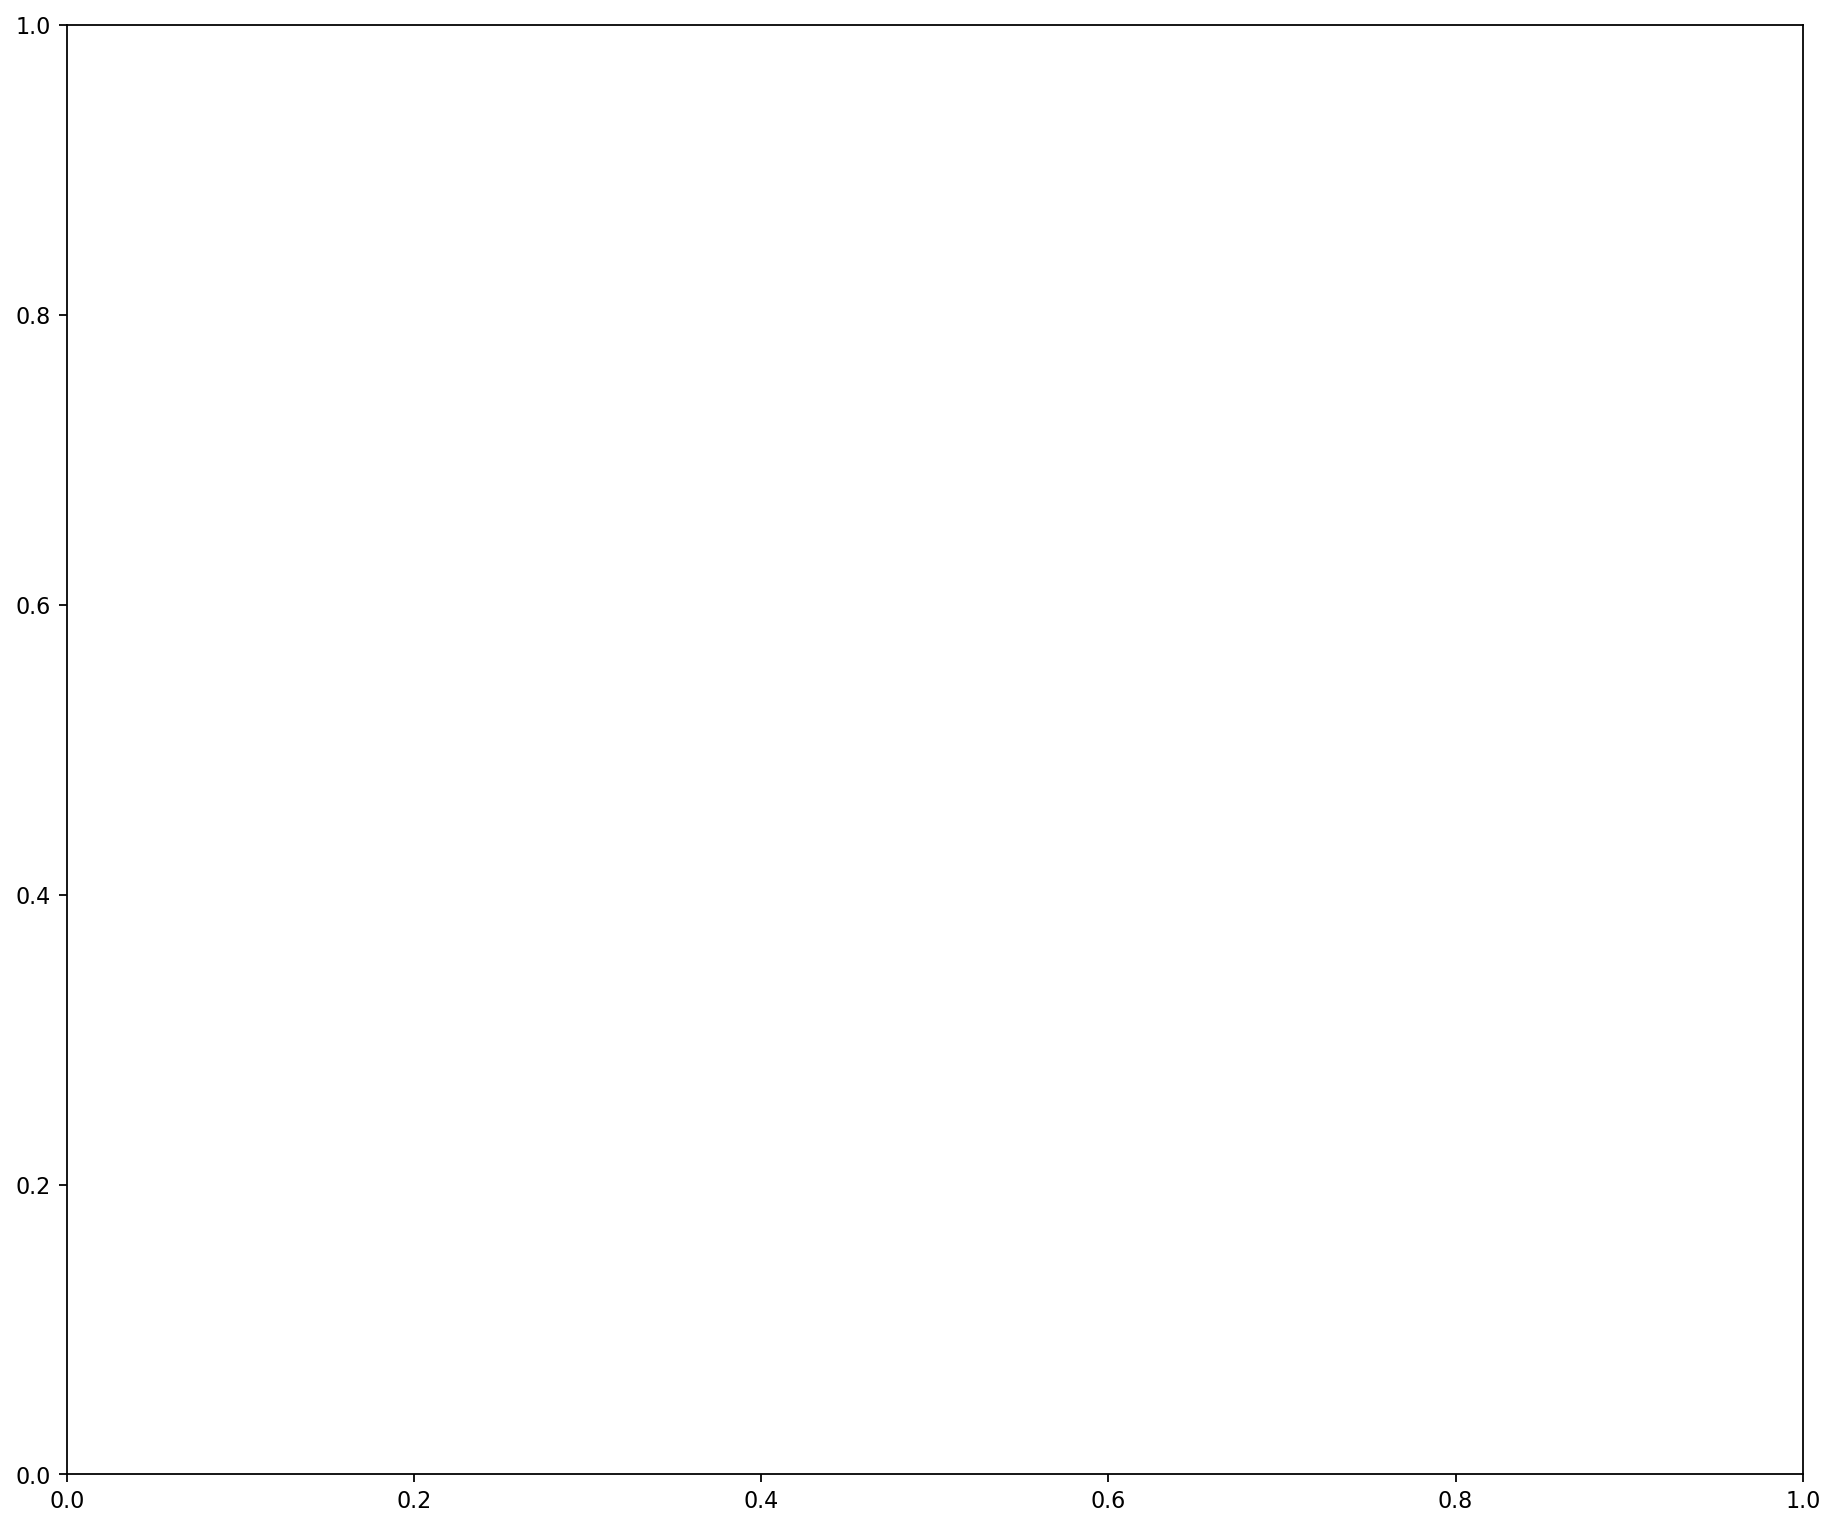

In [79]:
from matplotlib.pyplot import figure

figure(figsize=(14, 12), dpi=160)

pylab.plot(list(range(1, n)), np.real(trueGroundStates[1:]), label='true')
pylab.plot(list(range(1, n)), np.real(groundStatesNR[0][1:]), label='1 no rotation')
pylab.plot(list(range(1, n)), np.real(groundStatesNR[1][1:]), label='2 no rotation')
pylab.plot(list(range(1, n)), np.real(groundStatesR[0][1:]), label='1 rotation')
pylab.plot(list(range(1, n)), np.real(groundStatesR[1][1:]), label='2 rotation')

pylab.xlabel('Size')
pylab.xticks(list(range(1, n)))
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

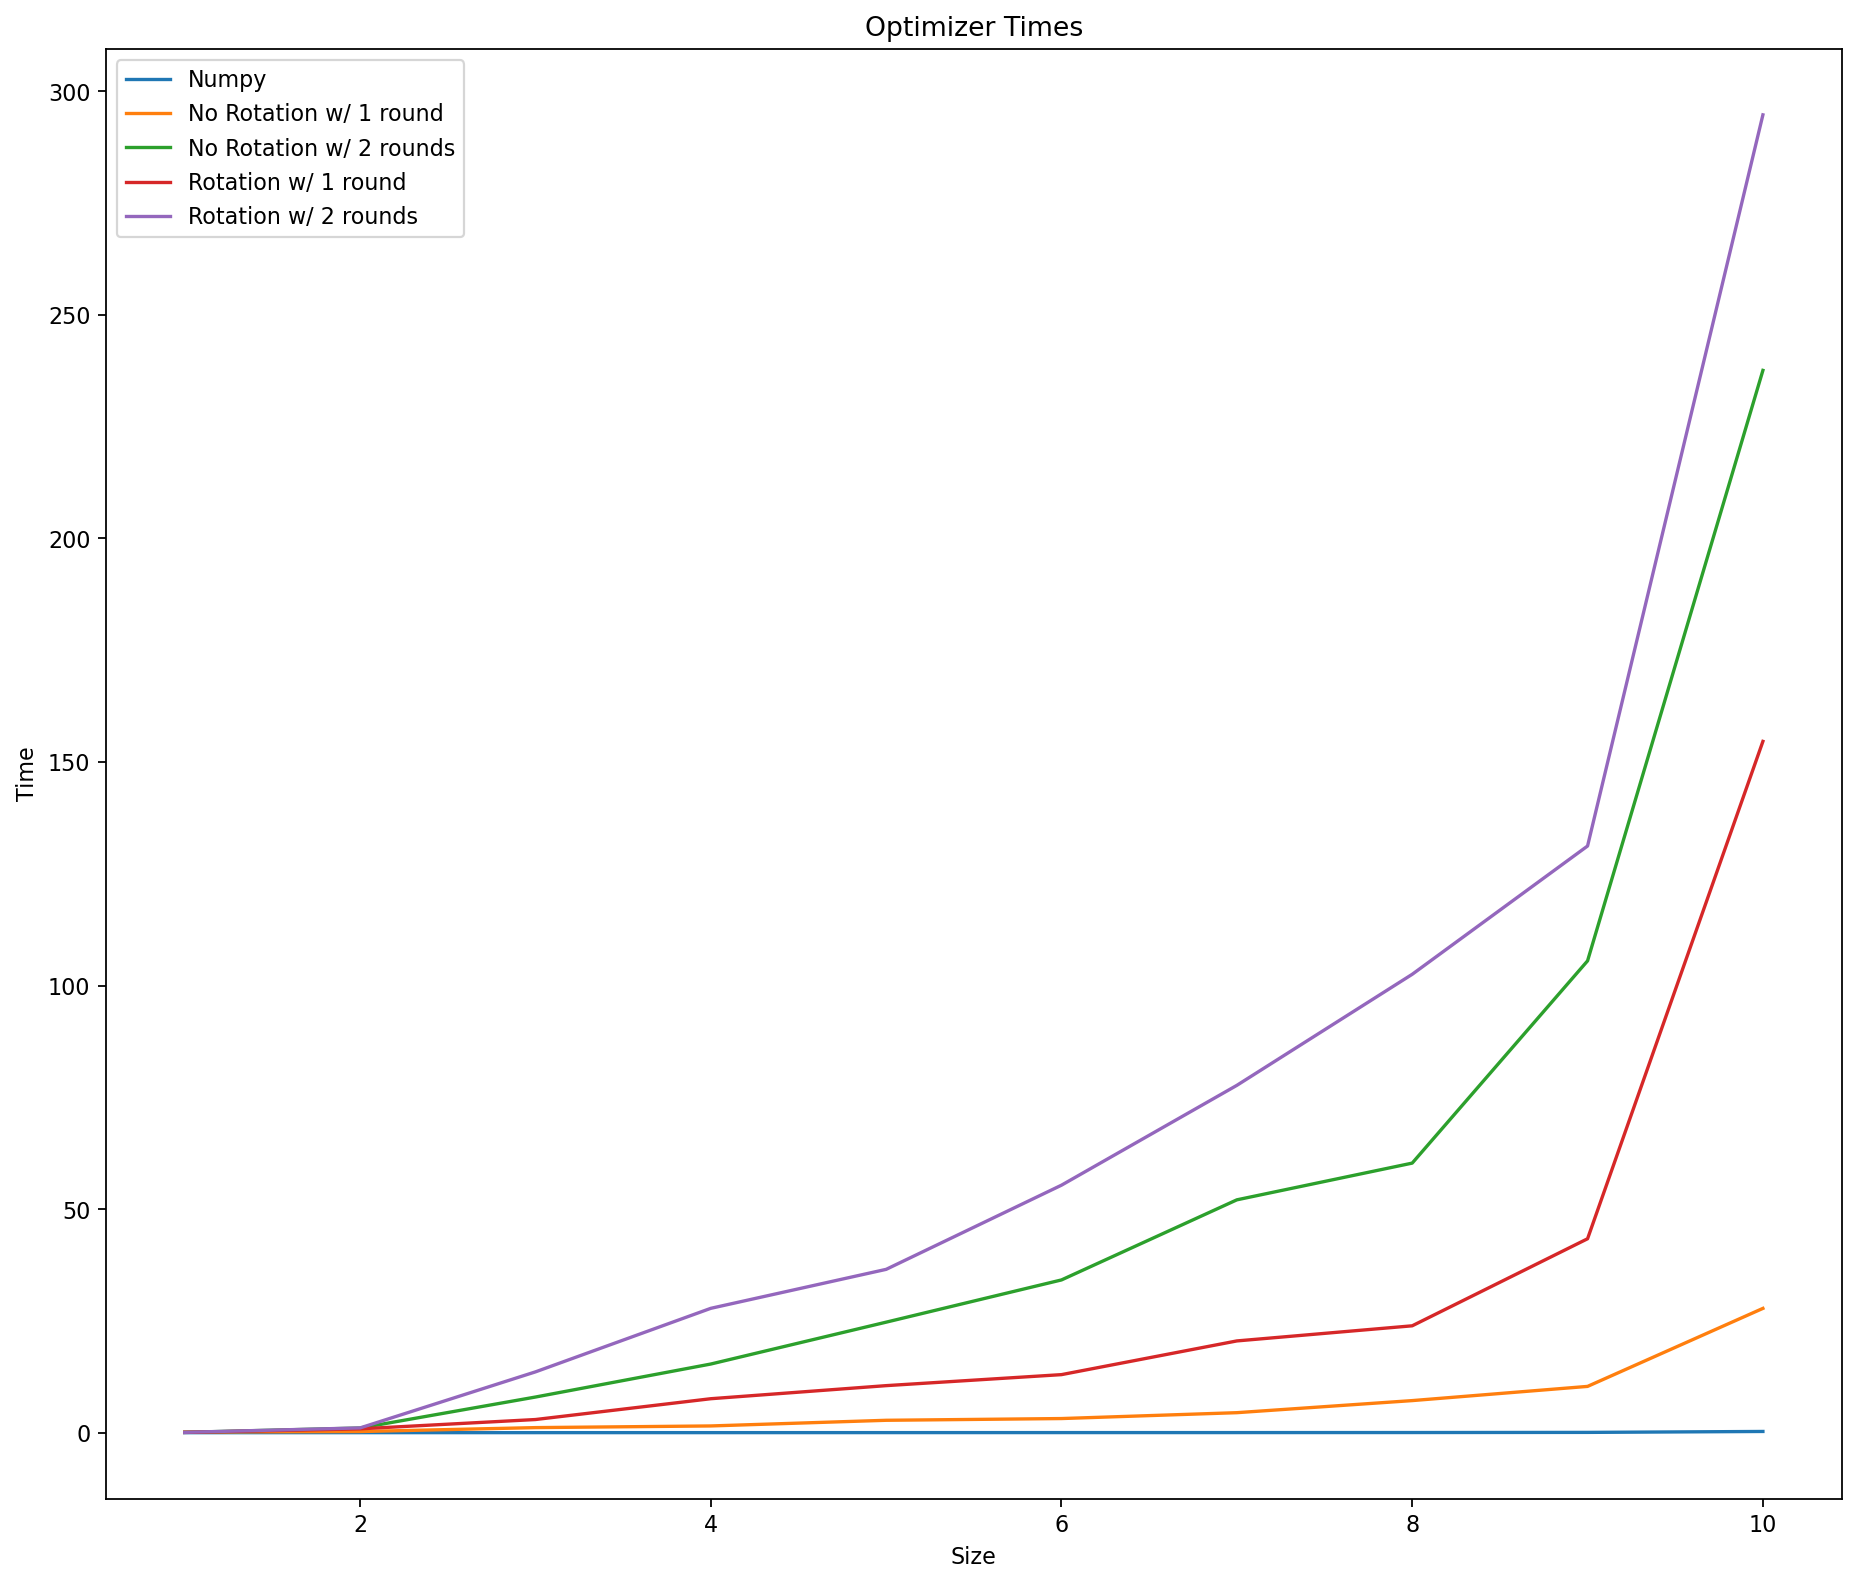

In [14]:
figure(figsize=(14, 12), dpi=160)

pylab.plot(list(range(1, n)),  trueTimes[1:], label='Numpy')
pylab.plot(list(range(1, n)),  np.sum(timesNR[0][1:], axis = 1), label='No Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesNR[1][1:], axis = 1), label='No Rotation w/ 2 rounds')
pylab.plot(list(range(1, n)),  np.sum(timesR[0][1:], axis = 1), label='Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesR[1][1:], axis = 1), label='Rotation w/ 2 rounds')

pylab.xlabel('Size')
pylab.ylabel('Time')
pylab.title('Optimizer Times')
pylab.legend(loc='upper left')

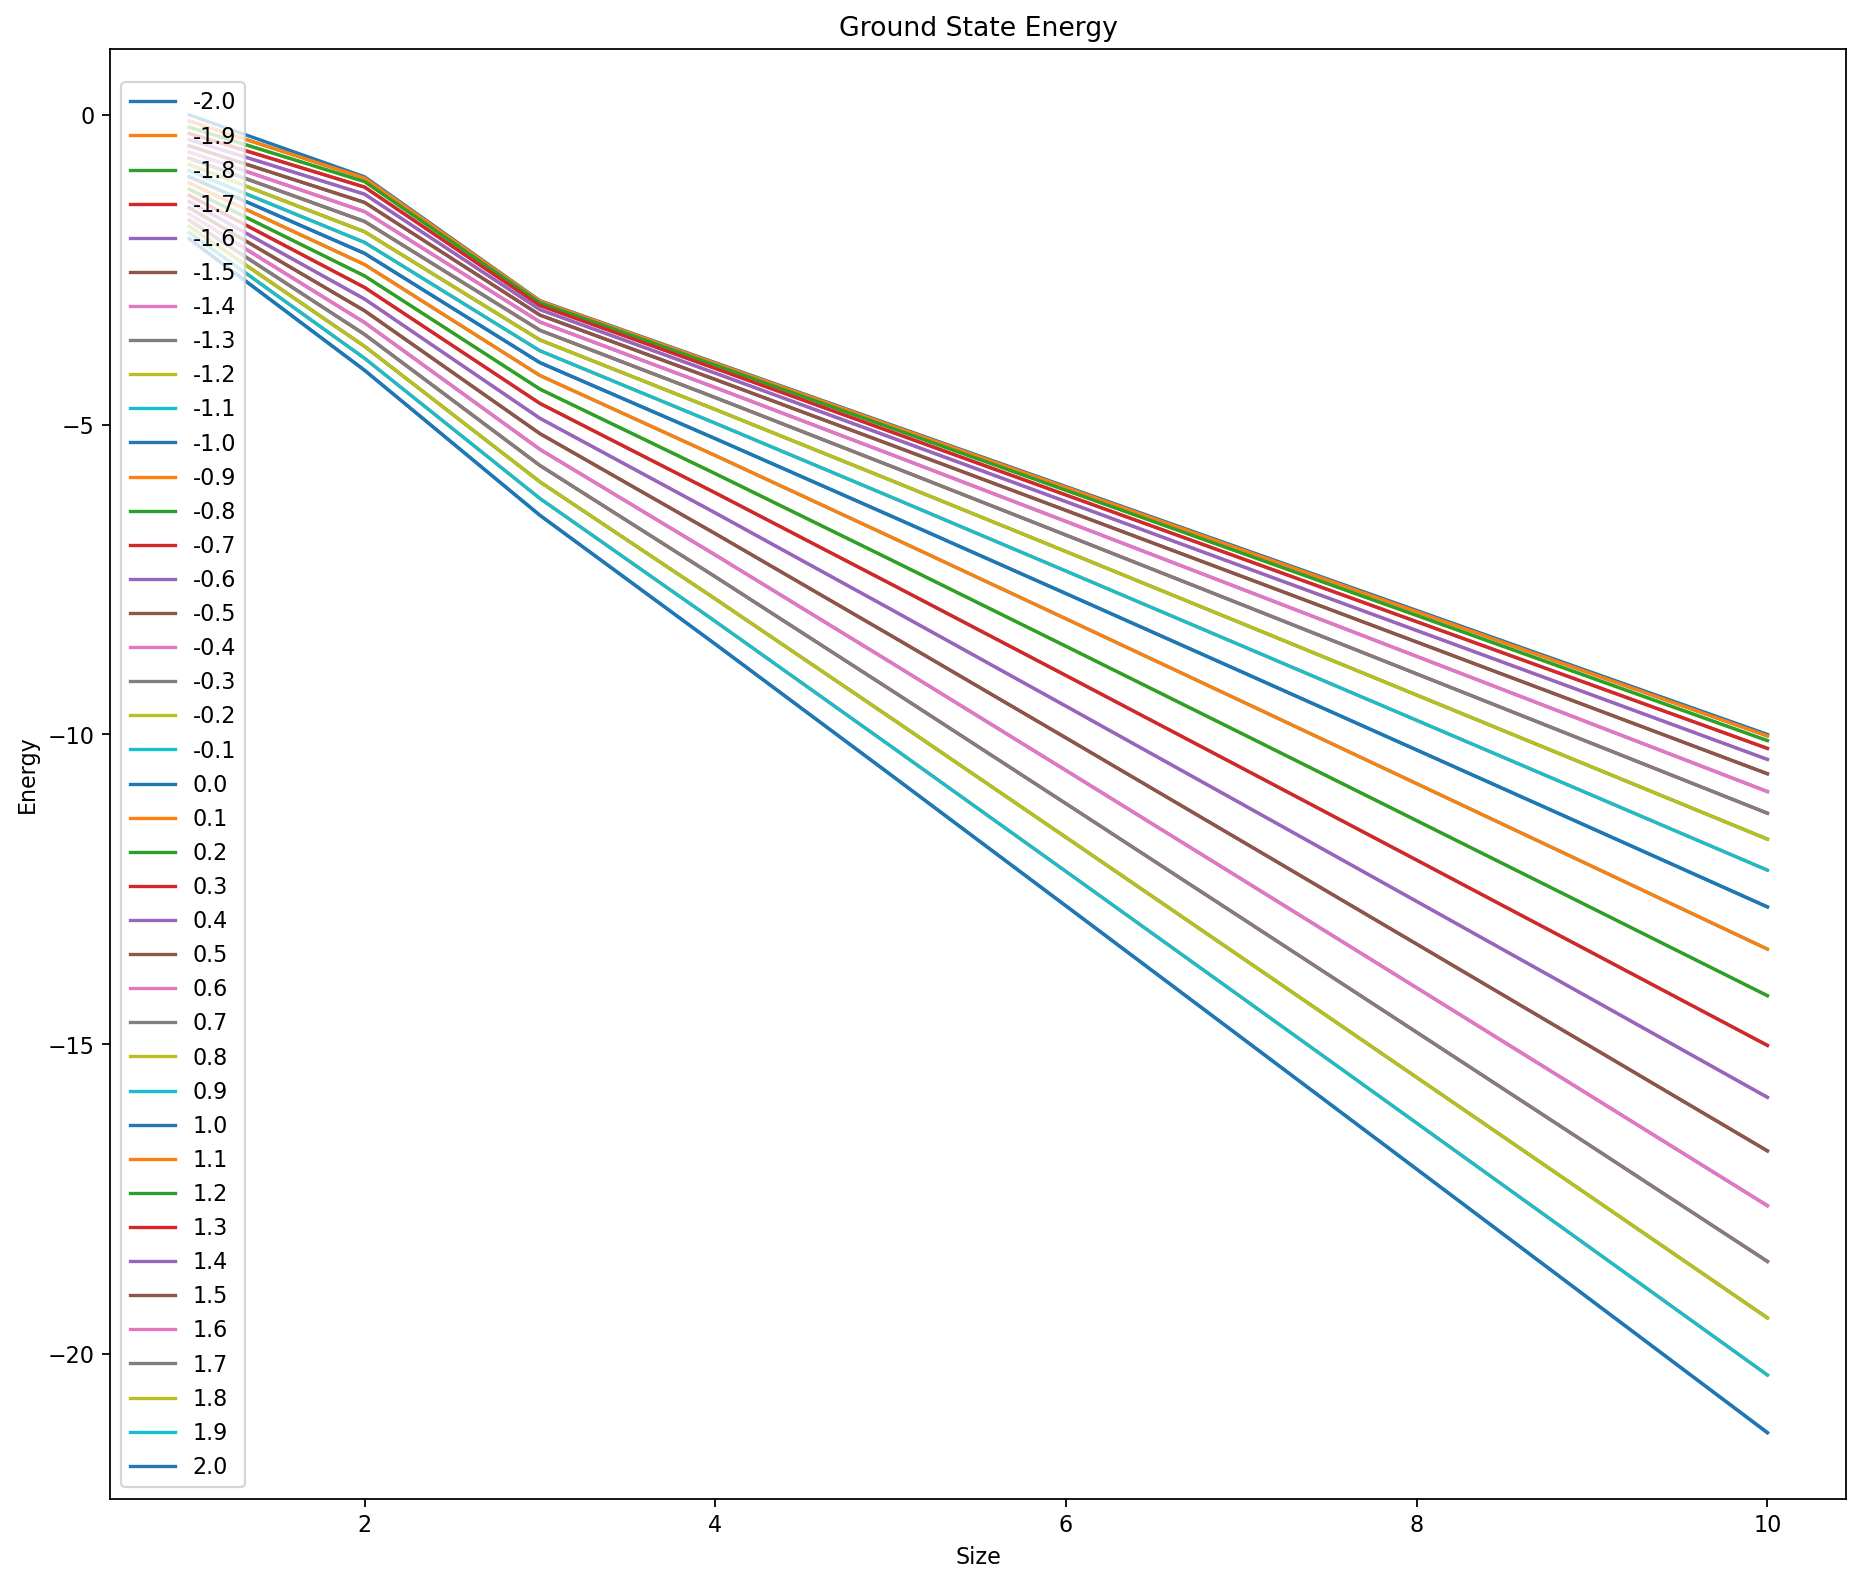

In [80]:
figure(figsize=(14, 12), dpi=160)

for i in range(s):
    pylab.plot(list(range(1, len(trueGroundStates[i]))), np.asarray(np.real(trueGroundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

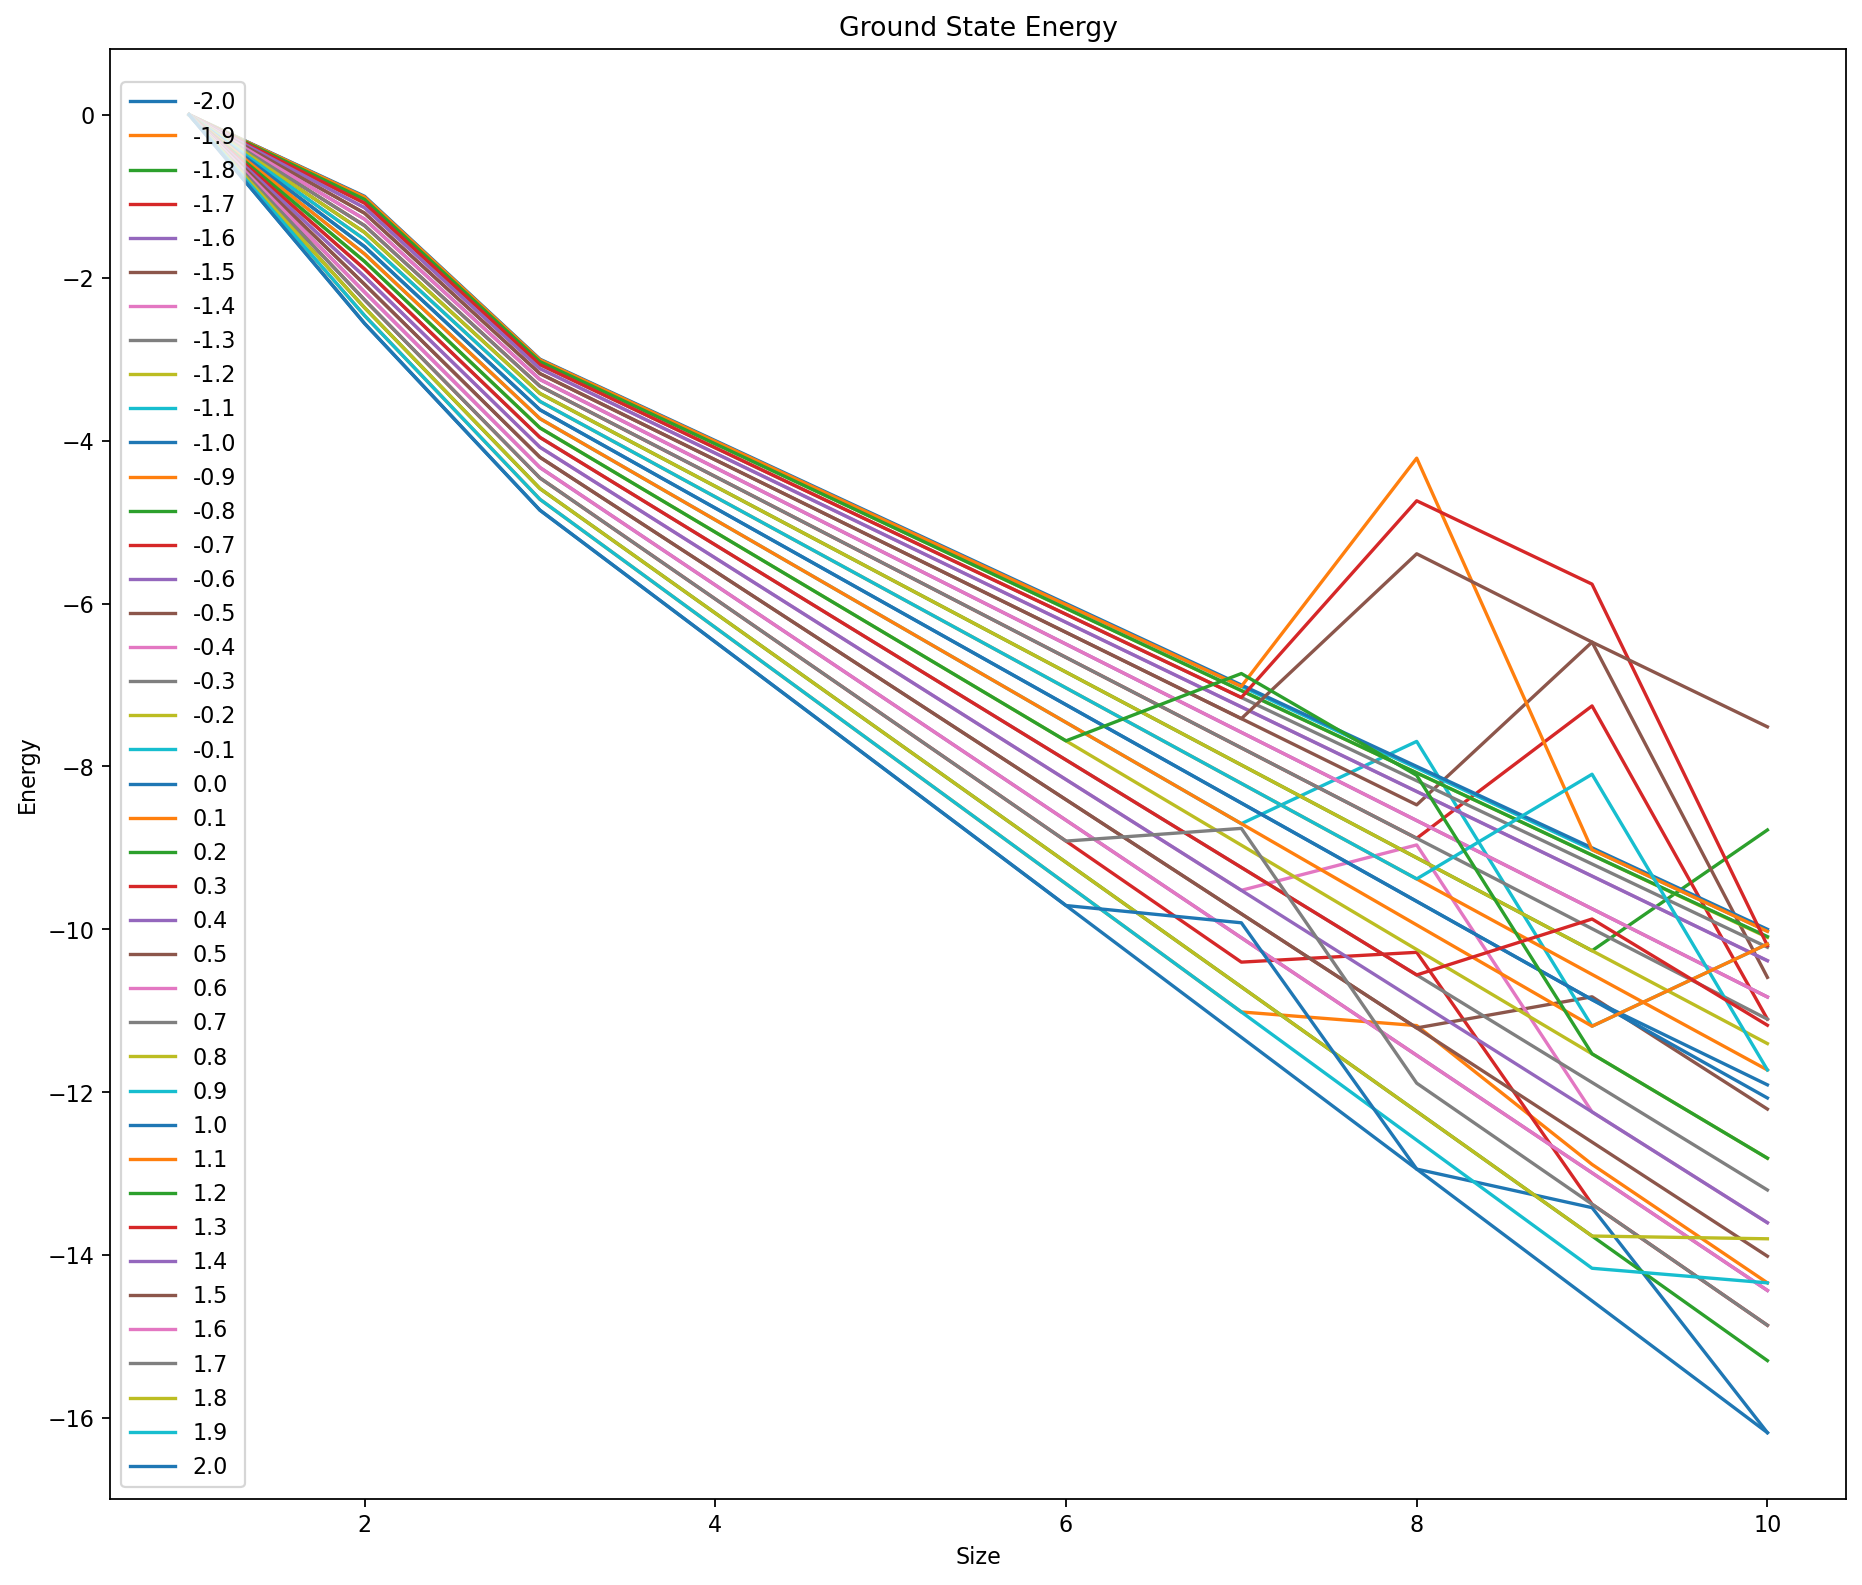

In [81]:
figure(figsize=(14, 12), dpi=160)

for i in range(s):
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

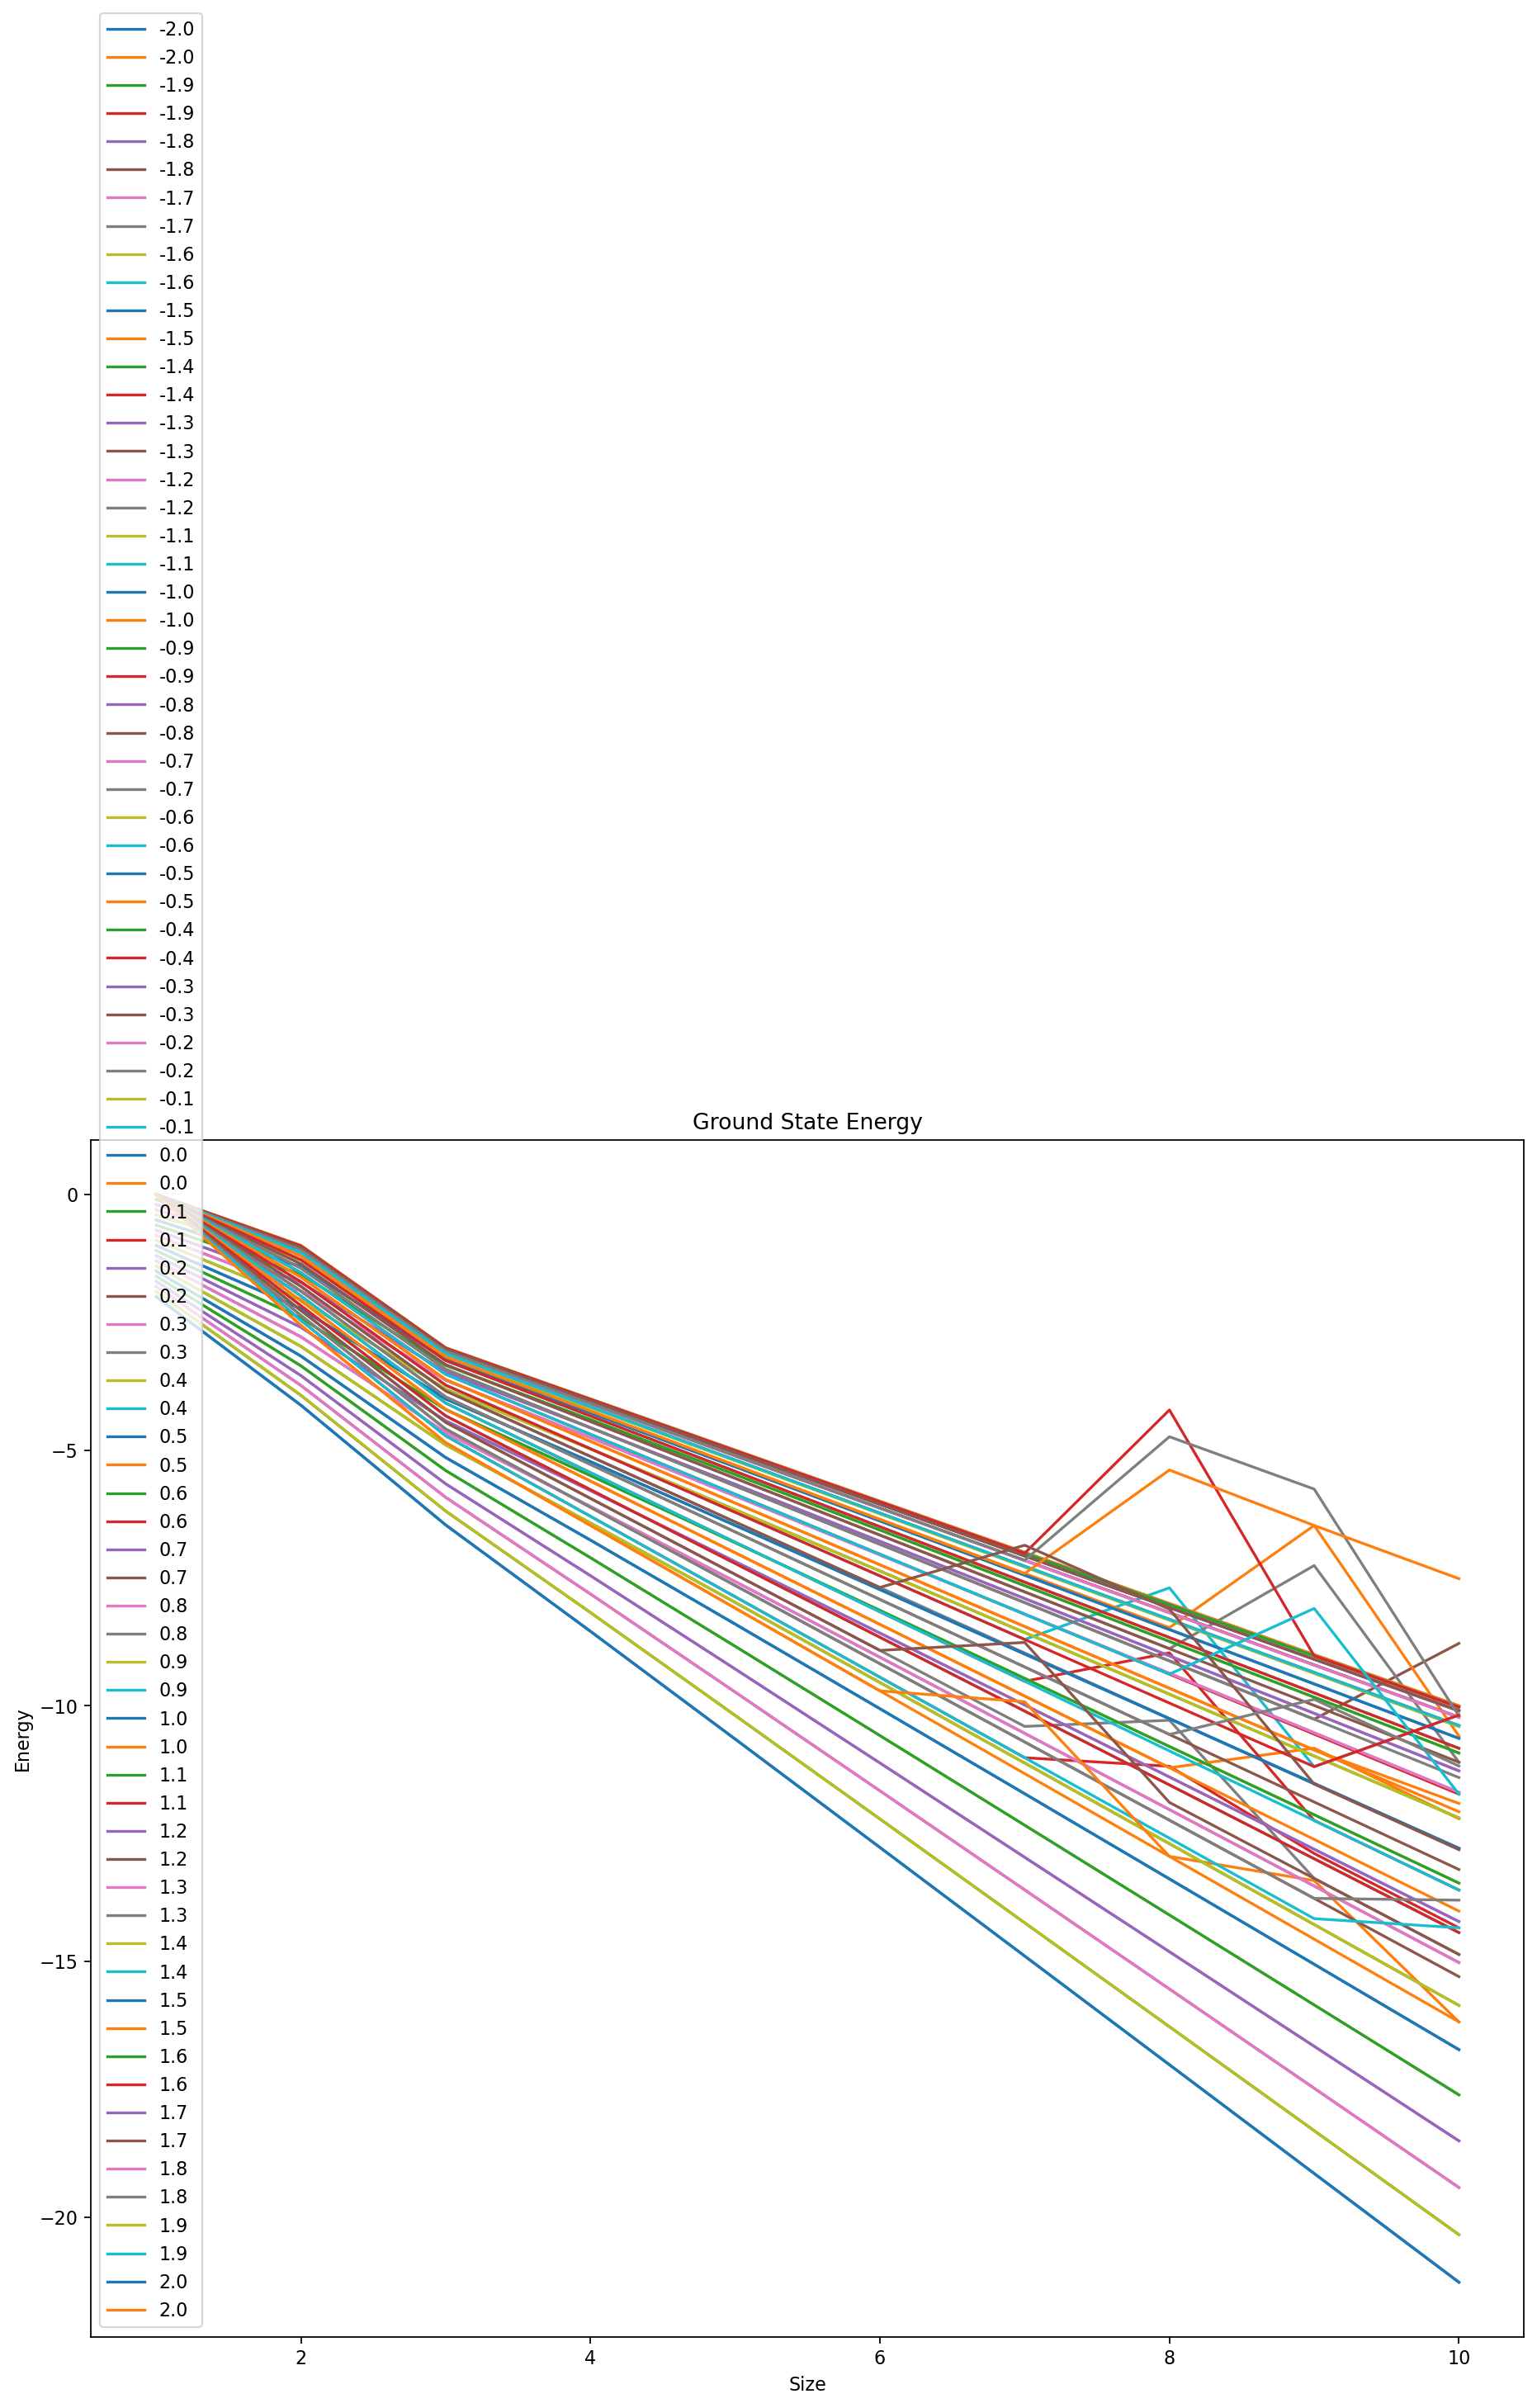

In [84]:
figure(figsize=(14, 12), dpi=160)

for i in range(s):
    pylab.plot(list(range(1, len(trueGroundStates[i]))), np.asarray(np.real(trueGroundStates[i][1:]), float), label=str(samples[i]))
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

In [92]:
print(results[5][5])

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 213,
    'eigenstate': array([ 3.25786809e-04-0.00078662j, -1.29947044e-03+0.00313665j,
       -1.29922109e-03+0.00313714j,  1.25096263e-02+0.00518144j,
       -1.29907548e-03+0.0031366j ,  5.18164066e-03-0.01250714j,
        1.25086425e-02+0.00518179j,  2.06655813e-02-0.0498793j ,
       -1.29938173e-03+0.00313713j,  5.18286210e-03-0.01250926j,
        5.18186770e-03-0.01251124j, -4.98896549e-02-0.02066588j,
        1.25096211e-02+0.00517997j, -4.98819165e-02-0.02066142j,
        2.06620237e-02-0.04988791j, -1.98932364e-01-0.08240253j,
       -1.29922656e-03+0.00313653j,  1.25076814e-02+0.00518029j,
        5.18124891e-03-0.01250885j,  2.06556420e-02-0.04988335j,
        5.18066820e-03-0.01250669j, -4.98734360e-02-0.02065643j,
       -4.98762049e-02-0.02066481j, -1.98898544e-01-0.08238262j,
        1.25085766e-02+0.00518245j,  2.06635379e-02-0.04988097j,
       -4.98856327e-02-0.02066735j, -1.98936140e-01-0.08239275j,
  